In [9]:
#imports:
import math
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from keras.layers.experimental import RandomFourierFeatures
import matplotlib.pyplot as plt

In [3]:
#Reading Data
data_ANN = pd.read_csv('GoldWeekly2001-2021.csv')

data_ANN = data_ANN.drop('Did_Win', axis=1)
data_ANN = data_ANN.drop('Volume', axis=1)

for i in range(len(data_ANN)):
    if data_ANN.iloc[i,-1] == 0:
        continue
    else:
        data_ANN.iloc[i,-1] = data_ANN.iloc[i,-1] / data_ANN.iloc[i,-2] * 100

data_ANN.head(n=4)

,Date,Open,High,Low,Close,Profit
0,1/1/2001,268.399994,268.399994,267.299988,268.000000,-1.529853
1,1/8/2001,268.000000,268.000000,263.899994,263.899994,0.151570
2,1/15/2001,263.299988,264.299988,263.200012,264.299988,-0.567537
3,1/22/2001,266.399994,266.399994,262.799988,262.799988,1.636232


In [4]:
#Preprocessing data:
data_labels = data_ANN['Date'].copy()
data_ANN = data_ANN.drop('Date', axis = 1)

#Split data for training and testing
X_train, X_Test_Val = train_test_split(data_ANN, test_size = 0.4, train_size = 0.6, shuffle = False)
X_test, X_val = train_test_split(X_Test_Val, test_size = 0.5, train_size = 0.5, shuffle = False)

#Removing the labels from the data.
train_labels = X_train['Profit'].copy()
X_train = X_train.drop('Profit', axis = 1)

test_labels = X_test['Profit'].copy()
X_test = X_test.drop('Profit', axis = 1)

val_labels = X_val['Profit'].copy()
X_val = X_val.drop('Profit', axis = 1)


arr_train_labels = np.array(train_labels)
arr_test_labels = np.array(test_labels)
arr_val_labels = np.array(val_labels)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [5]:
def univariate_processing(variable, window):
    # create empty 2D matrix from variable
    V = np.empty((len(variable)-window+1, window))
    
    # take each row/time window
    for i in range(V.shape[0]):
        V[i,:] = variable[i : i+window]
    
    V = V.astype(np.float32) # set common data type
    
    return V

def RNN_regprep(df, y, len_input, len_pred):
    # create 3D matrix for multivariate input
    X = np.empty((df.shape[0]-len_input+1, len_input, df.shape[1]))
    
    # Iterate univariate preprocessing on all variables - store them in X
    for i in range(df.shape[1]):
        X[ : , : , i ] = univariate_processing(df[:,i], len_input)
    
    # create 2D matrix of y sequences
    y = y.reshape((-1,))
    Y = univariate_processing(y, len_pred)
    
    ## Trim dataframes as explained
    X = X[ :-(len_pred + 1) , : , : ]
    Y = Y[len_input:-1 , :]
    
    # Set common datatype
    X = X.astype(np.float32)
    Y = Y.astype(np.float32)
    
    return X, Y

len_input = 10
no_vars = 4
len_pred = 1

X_train, arr_train_labels = RNN_regprep(X_train, arr_train_labels, len_input, len_pred)
X_test, arr_test_labels = RNN_regprep(X_test, arr_test_labels, len_input, len_pred)
X_val, arr_val_labels = RNN_regprep(X_val, arr_val_labels, len_input, len_pred)

In [6]:
#Create RNN(LSTM) Model

RNN = Sequential()
RNN.add(LSTM(50, activation="linear", input_shape=(len_input, no_vars)))
RNN.add(Dense(1))

RNN.summary()

RNN.compile(optimizer="adam", loss="MAE", metrics="MAE") #Mean Absolute Error

history = RNN.fit(X_train, arr_train_labels, validation_data=(X_val, arr_val_labels), epochs=100, verbose=2, shuffle=False)

predictions = RNN.predict(X_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11000     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
20/20 - 4s - loss: 301.5251 - MAE: 301.5251 - val_loss: 443.1832 - val_MAE: 443.1832
Epoch 2/100
20/20 - 1s - loss: 90.5548 - MAE: 90.5548 - val_loss: 174.7422 - val_MAE: 174.7422
Epoch 3/100
20/20 - 1s - loss: 191.2949 - MAE: 191.2949 - val_loss: 135.6089 - val_MAE: 135.6089
Epoch 4/100
20/20 - 1s - loss: 163.7073 - MAE: 163.7073 - val_loss: 559.6140 - val_MAE: 559.6140
Epoch 5/100
20/20 - 1s - loss: 212.0571 - MAE: 212.0571 - val_loss: 234.4966 - val_MAE: 234.4966
Epoch 6/100
20/20 - 1s - loss: 

In [18]:
currentMoney = 1000.0

print("If you invested $1000 from " + data_labels[627] + " to " + data_labels[835] + ".")

for i in range((len(X_test)-1)):
   if (float(predictions[i]) > 0.5):
       currentMoney = currentMoney * ((float(arr_test_labels[i]) / 100) + 1)
   
print("\t$" + str(round(currentMoney,2)) + " : With our RNN(LSTM) Model.") #then do this for validation.

currentMoney = 1000.0

for i in range((len(X_test)-1)):
    #If we blindly left our money in the market as opposed to using our model.
   if (True):
       currentMoney = currentMoney * ((float(arr_test_labels[i]) / 100) + 1)
   
print("\t$" + str(round(currentMoney,2)) + " : Without our Model.") #then do this for validation.

print("\nAs you can see, this was a bad time period to invest in the Gold Market, yet our model was able generate profit throughout a bad market.")

If you invested $1000 from 1/7/2013 to 1/2/2017.
	$1028.45 : With our RNN(LSTM) Model.
	$710.77 : Without our Model.

As you can see, this was a bad time period to invest in the Gold Market, yet our model was able generate profit throughout a bad market.


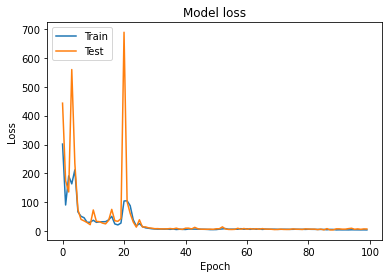

In [10]:
#Plotting the loss of our model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

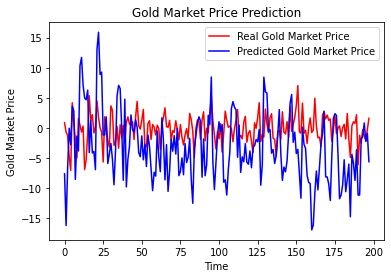

In [13]:
#Plotting predictions vs. Actual
plt.plot(arr_test_labels, color = 'red', label = 'Real Gold Market Price')
plt.plot(predictions, color = 'blue', label = 'Predicted Gold Market Price')
plt.title('Gold Market Price Prediction')
plt.xlabel('Time')
plt.ylabel('Gold Market Price')
plt.legend()
plt.show()